In [1]:
import os
import numpy as np
import scipy
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import glob
from astropy.io import fits
sys.path.append('src/')
from utils import *
from dark_correct import *
from flat_field import *
from sky_subtraction import *

In [2]:
matplotlib.style.use('seaborn-ticks')
matplotlib.rc('lines',linewidth=2)
matplotlib.rc('axes',labelsize=30)
matplotlib.rc('figure',figsize=(12,8))
matplotlib.rc('xtick',labelsize=30)
matplotlib.rc('ytick',labelsize=30)

## Identify the data directory (where your data lives), and the output directory (where you want your final image to go), and let 'er rip! This next cell should automatically peruse your data directory for any fits files. It will then go through their headers and identify all the unique objects you've looked at, ignoring flats, darks, alignments, etc. At the end, you should have a list of all the targets that have data in that directory. Don't see your target? Make sure it's in the right directory!

In [3]:
datadir = 'Raw_Data/Test_Data/' #You change this!
outdir = 'Results/'


#################################


files = [os.path.basename(x) for x in glob.glob(datadir+'*')]           

#Want to make a target list for every target. This is the list that contains all target names, later
#We'll have a list for the data of every target
target_list = []

#Here we go through every file and check the objects name. If its a flat or a dark, we continue
#If it's a target, we check if it's in target_list. If it is, we continue. If it's not, we add it
for f in files:
    try:
        header = fits.getheader(datadir+f)
        obj = header['OBJECT']
        if (len(target_list) == 0 and 'dark' not in obj.lower() and 'flat' not in obj.lower()
            and 'alignment' not in obj.lower() and 'junk' not in obj.lower() and 'seeing' not in obj.lower()
            and 'optimization' not in obj.lower() and 'test' not in obj.lower()):
            target_list.append(obj)
        if obj in target_list:
            continue
        elif 'dark' in obj.lower():
            continue
        elif 'flat' in obj.lower():
            continue
        elif 'alignment' in obj.lower():
            continue
        elif 'junk' in obj.lower():
            continue
        elif 'seeing' in obj.lower():
            continue
        elif 'optimization' in obj.lower():
            continue
        elif 'test' in obj.lower():
            continue
        else:
            target_list.append(obj)
    except OSError:
        continue
    except KeyError:
        continue
            
#Optional part, but helpful. Sometimes the names of targets can mess up the later parts of this code, especially
#if they have strange characters. Here I replace two common ones with an acceptable replacement.
            
target_list_fixed = []

#The minus and + signs in some targets mess up the next part, so I replace them here
for i in range(len(target_list)):
    j = target_list[i].replace('-','_')
    k = j.replace('+','t')
    target_list_fixed.append(k)
    
target_list = target_list_fixed #just change it's name back for consistency
    
print('List of all the targets in your data directory:')
print(target_list)



List of all the targets in your data directory:
['172370679']


## Now You start off by picking a target from the list, and we will analyze that target. This next cell basically makes a list of all the files associated with that target. It also generates lists of flats and darks, and a few other odds and ends for use later

In [4]:
#We've identified our list of targets, now we pick our target and proceed
#I may go back and make this a loop at some point, but for now it is one at a time. 

#edit this line if you wanna change targets
target = target_list[0]



#these definitions ensure that all these lists are redifined for every target. Though the flat list and the
#dark list should stay the same between runs, the object list will change on each iteration. Essentially, each
#iteration is a new target, and so this list gets recycled every time
flat_list = [] #list of all the flats, duh
dark_list = [] # list of all the darks, dummy!
object_list = [] #this is a list that contains all the FILES that each target has, every exposure. Not
#to be confused with the actual target list, which only has one entry for every star we looked at
drkhdr_list =[] #this keeps the header for each dark. This is useful later for when we're sorting these by 
#exposure time
tot_exptime = 0 # this keeps track of how many seconds total we looked at this target



#Open the text file with the vetos in it
#there is another script that reads everything and auto vetos stuff for SNR reasons, or other poor quality indicators
veto_list = [line.rstrip('\n') for line in open(datadir+'veto_list.txt')]
#Now we organize this into flats and targets


print('Target: '+target)
#make a list of frames to veto
flat_veto_list = []
target_veto_list = []


for veto in veto_list:
    header = fits.getheader(datadir+veto)
    obj = header['OBJECT']
    objf = obj.replace('-','_')#having trouble with minus/plus signs again
    objk = objf.replace('+','t')
    if 'flat' in obj.lower():
            flat_veto_list.append(veto)
    elif objk == target:
        target_veto_list.append(veto)
    else:
        continue


##Let's add the ability to manually input vetos for this target; Let's manually put them in the veto list for now
mantarglist = (list(map(str, input(str(target)+': Enter Manual Veto Targets in fits file form, delineated by spaces i.e. s0300.fits').split())))
manflatlist = (list(map(str, input(str(target)+': Enter Manual Veto Flats in fits file form, delineated by spaces i.e. s0300.fits').split())))
        
        
for targ in mantarglist:
    target_veto_list.append(targ)
            
for flat in manflatlist:
    flat_veto_list.append(flat)

#This part basically takes objects and sorts them into either flats, darks, or targets
#Need to move flats/darks here, because I only want them by night
#The two if/else parts correspond to when the id is two digits or three
for f in files:
    try:
        header = fits.getheader(datadir+f)
        obj = header['OBJECT']
        objf = obj.replace('-','_')#having trouble with minus/plus signs again
        objk = objf.replace('+','t')
        if 'flat' in obj.lower():
            flat_list.append(f)
        elif 'test' in obj.lower():
            flat_list.append(f)
        elif 'dark' in obj.lower():
            dark_list.append(f)
            drkhdr_list.append(int(float(header['ITIME'])/1000))
        elif objk == target:
            object_list.append(f)
            tot_exptime = tot_exptime + float(header['ITIME'])/1000
    except OSError:
            continue
    except KeyError:
            continue

#I recommend using this point to ensure that all the right fits files are here for each target
#These have not removed the veto frames yet
if(len(object_list)==0):
    sys.exit('Nothing in the object list')
        



#Now we remove the bad/overexposed frames in the veto list           
for veto in target_veto_list:
    for ID in object_list:
        if ID == veto:
            object_list.remove(ID)
            continue


for veto in flat_veto_list:
    for ID in flat_list:
        if ID == veto:
            flat_list.remove(ID)
            continue


#We don't want targets with only a few images
if len(object_list)<5:
    sys.exit('Too few images')
            
print('Object List:')


#let's make a list that contains all our exposures

all_images_list = []

all_images_list = flat_list + object_list + dark_list

  
object_filter_list = []
        
#let's make a list of all the filters for a target, in case they change        
for i in range(len(object_list)):
    try:
        header = fits.getheader(datadir+object_list[i])
        filt = header['FILT1NAM']
        if len(object_filter_list) == 0:
            object_filter_list.append(filt)
        elif filt not in object_filter_list:
            object_filter_list.append(filt)
    except OSError:
        continue
                
       



    ############# Get the Image Data   ###################

raw_image_data = {}

        
for image_name in all_images_list:
    try:
        raw_image_data[image_name] = fits.getdata(datadir+image_name)
    except OSError:
        continue
                
                
                
#now we want to loop and do the rest of the code for each filter, but we need to make a new target list
#for all the targets in a particular filter
object_filter_list2 = [object_filter_list[0]]
        
for filter_ in object_filter_list2:
    newobjectlist = []
    for j in range(len(object_list)):              
        header = fits.getheader(datadir+object_list[j])
        filt = header['FILT1NAM']
        if filter_ == filt:
            newobjectlist.append(object_list[j])
        else:
            continue

object_list = newobjectlist
print(object_list)

Target: 172370679
172370679: Enter Manual Veto Targets in fits file form, delineated by spaces i.e. s0300.fits
172370679: Enter Manual Veto Flats in fits file form, delineated by spaces i.e. s0300.fits
Object List:
['s0210.fits', 's0207.fits', 's0216.fits', 's0221.fits', 's0218.fits', 's0222.fits', 's0219.fits', 's0204.fits', 's0208.fits']


In [5]:
################################
#       Dark Correction        #
################################

darkcor_list_in = object_list + flat_list #we will dark correct all object images and flat images

#make a master dark for each exposure time
master_dark_dict = generate_master_darks(dark_list, drkhdr_list, datadir)

darkcor_data_out = {} ## dictionary for the dark-corrected images

for im in darkcor_list_in:  
    try:
        darkcor_data_out[im] = dark_correct(im, raw_image_data, master_dark_dict, datadir)
    except OSError:
        continue



Now correcting s0210.fits using exposure time 70 s
Now correcting s0207.fits using exposure time 70 s
Now correcting s0216.fits using exposure time 70 s
Now correcting s0221.fits using exposure time 70 s
Now correcting s0218.fits using exposure time 70 s
Now correcting s0222.fits using exposure time 70 s
Now correcting s0219.fits using exposure time 70 s
Now correcting s0204.fits using exposure time 70 s
Now correcting s0208.fits using exposure time 70 s
Now correcting s0119.fits using exposure time 35 s
Now correcting s0123.fits using exposure time 15 s
Now correcting s0118.fits using exposure time 35 s
Now correcting s0125.fits using exposure time 15 s
Now correcting s0128.fits using exposure time 15 s
Now correcting s0124.fits using exposure time 15 s
Now correcting s0127.fits using exposure time 15 s
Now correcting s0126.fits using exposure time 15 s
Now correcting s0117.fits using exposure time 35 s
Now correcting s0121.fits using exposure time 35 s
Now correcting s0120.fits using

src/flat_field.py:37: RuntimeWarning: divide by zero encountered in true_divide
  flat_darkcor_data_out[im] = darkcor_data_out[im]/master_flat
src/flat_field.py:37: RuntimeWarning: invalid value encountered in true_divide
  flat_darkcor_data_out[im] = darkcor_data_out[im]/master_flat
src/utils.py:33: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(B), origin='lower', cmap='gray')


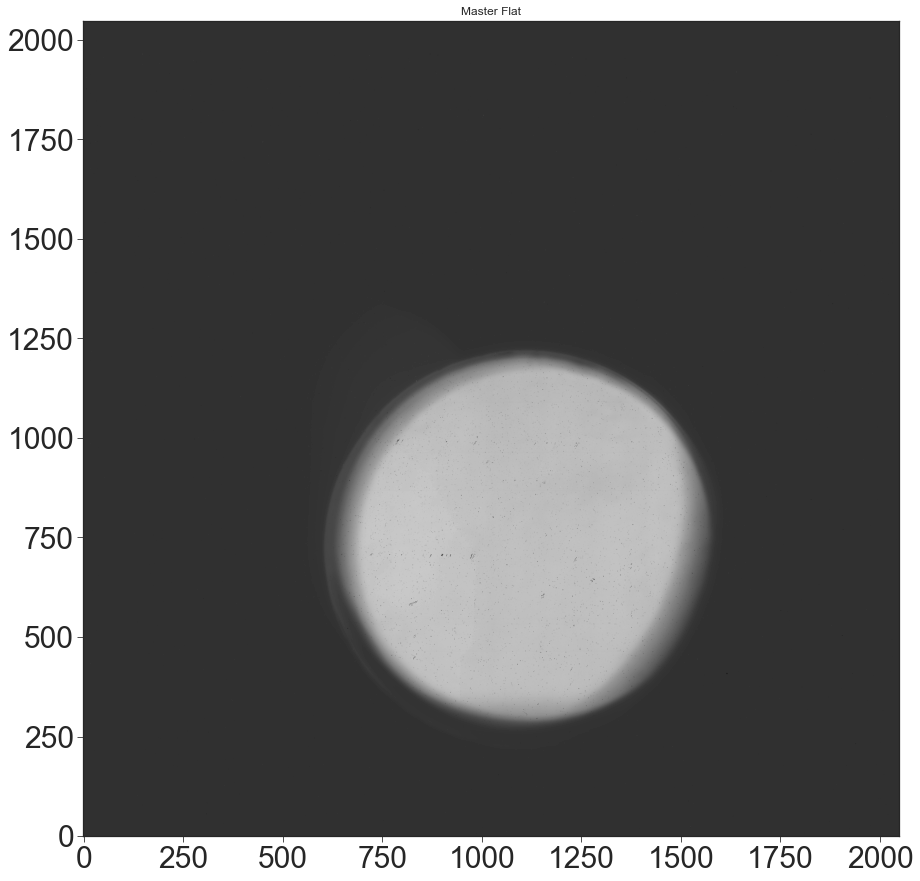

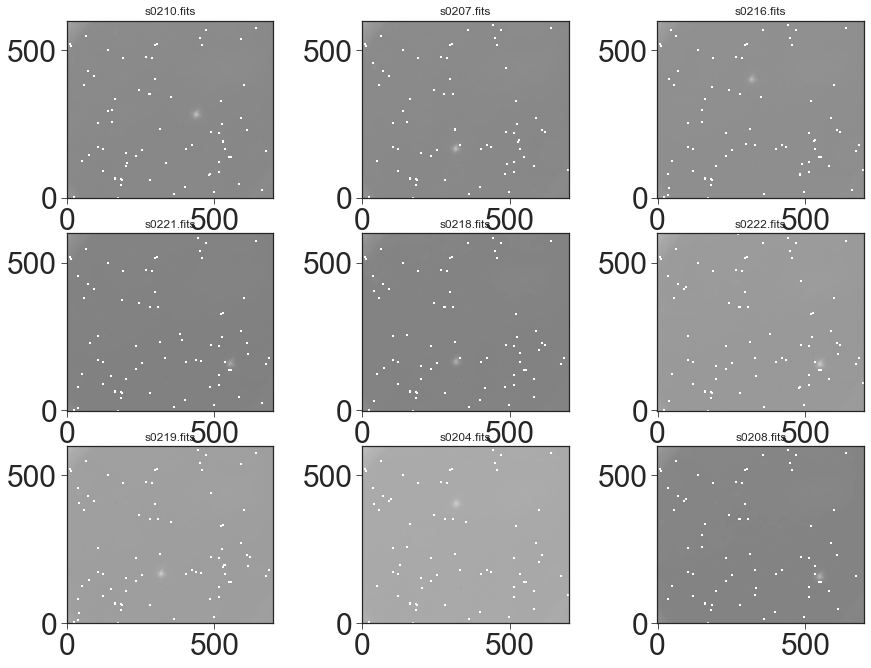

In [6]:
################################
#       Flat Correction        #
################################


#make a master flat
master_flat = make_master_flats(flat_list, filter_, darkcor_data_out, datadir)

#plot it
plt.figure(figsize=(15,15))
plt.imshow((master_flat), origin='lower', cmap='gray')
plt.title('Master Flat')

#flat field the images
flat_darkcor_data_out = flat_field(object_list, master_flat, darkcor_data_out)



targetcube_window = np.stack([flat_darkcor_data_out[science_frame][450:1050,750:1450] for science_frame in object_list],axis=0)

## show the images: 
plot_grid(targetcube_window,object_list)
         

In [7]:
################################
#          Sigma Clip          #
################################

flat_darkcor_sigmacut_data = sigma_clip(object_list, flat_darkcor_data_out)
#flat_darkcor_sigmacut_data = flat_darkcor_data_out

s0210.fits
s0207.fits
s0216.fits
s0221.fits
s0218.fits
s0222.fits
s0219.fits
s0204.fits
s0208.fits


Sky Subtracting images with exp time = 70.0 s
Positions = 4


<Figure size 864x576 with 0 Axes>

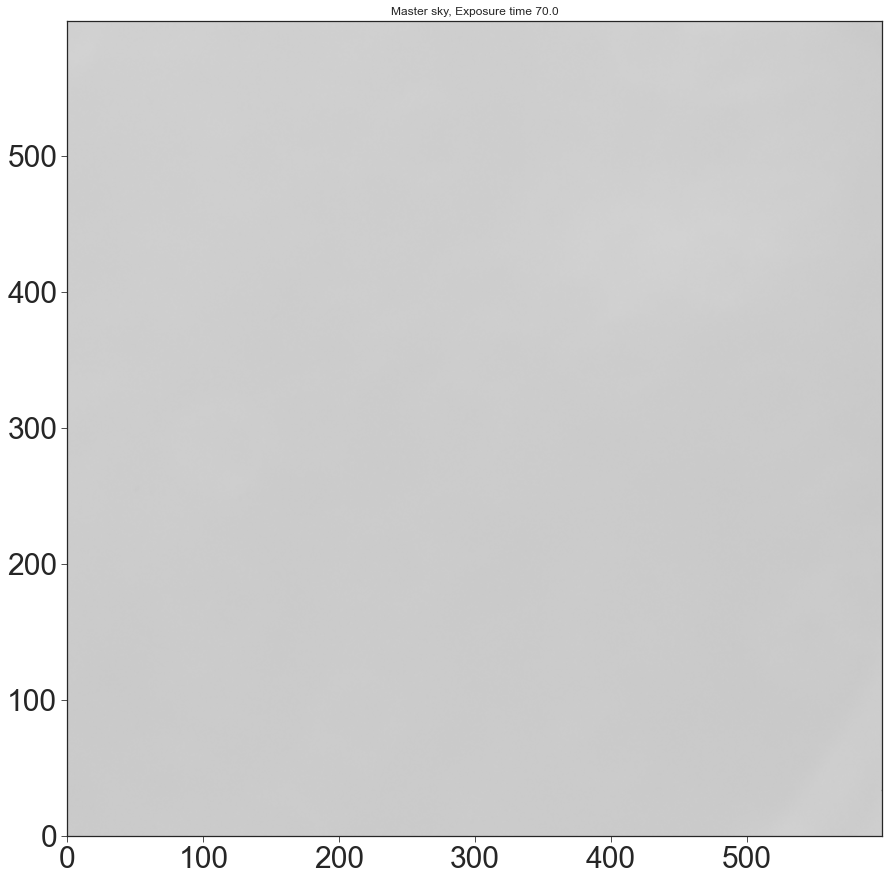

In [11]:
################################
#       Sky Subtraction        #
################################

master_sky, exp_dict, center = make_master_sky(object_list, flat_darkcor_sigmacut_data, datadir)
exposuretimes = master_sky.keys()

graymin = 1.25
graymax = 3

for key in exposuretimes:
    plt.figure(1)
    plt.figure(figsize=(15,15));
    plt.title('Master sky, Exposure time '+str(key));
    plt.imshow(np.log10(master_sky[key]), origin='lower', cmap='gray',vmin=graymin,vmax=graymax)
    plt.show()

sky_flat_darkcor_data_out = sky_subtract(object_list, exposuretimes, flat_darkcor_sigmacut_data, exp_dict, master_sky)




/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10


<Figure size 864x576 with 0 Axes>

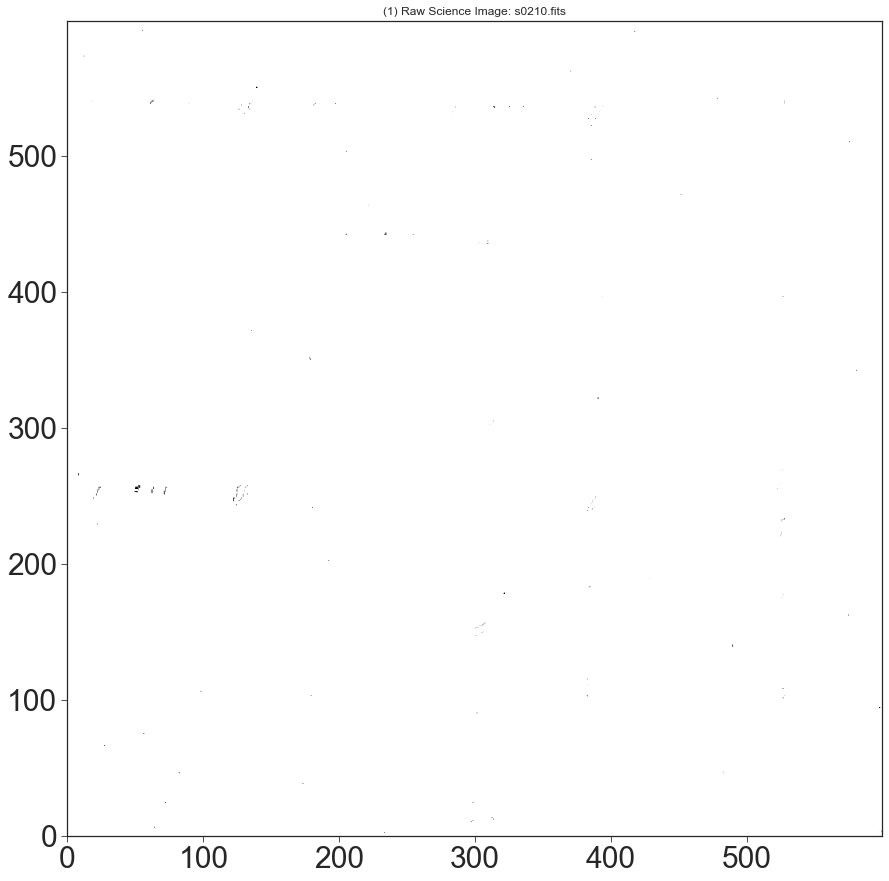

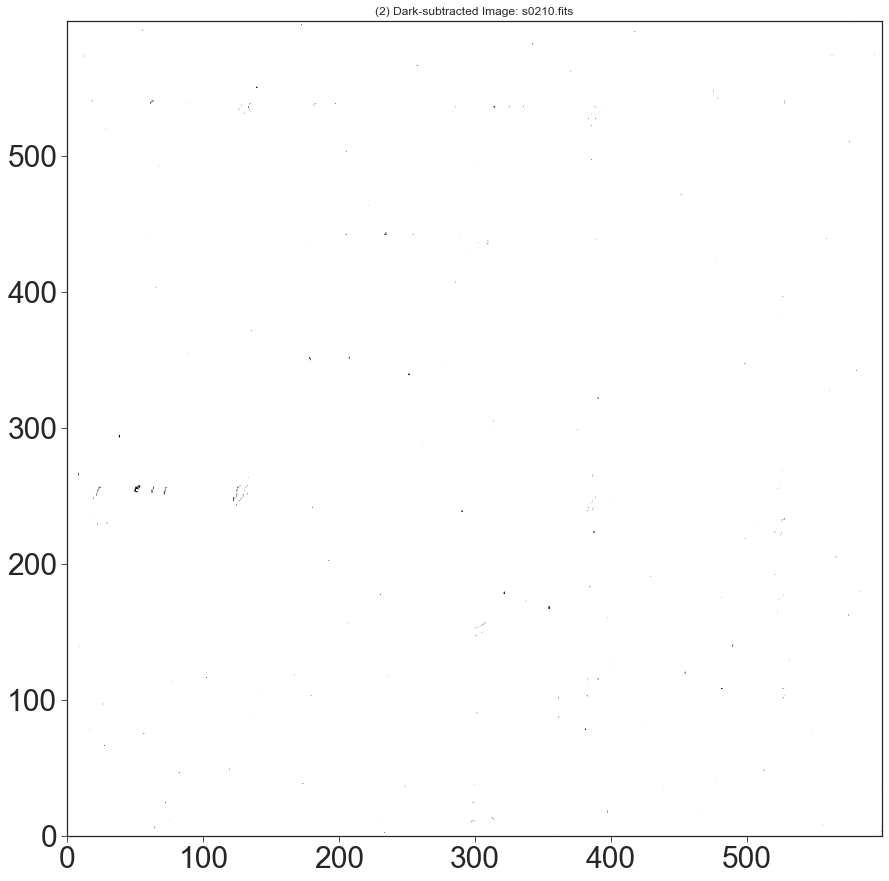

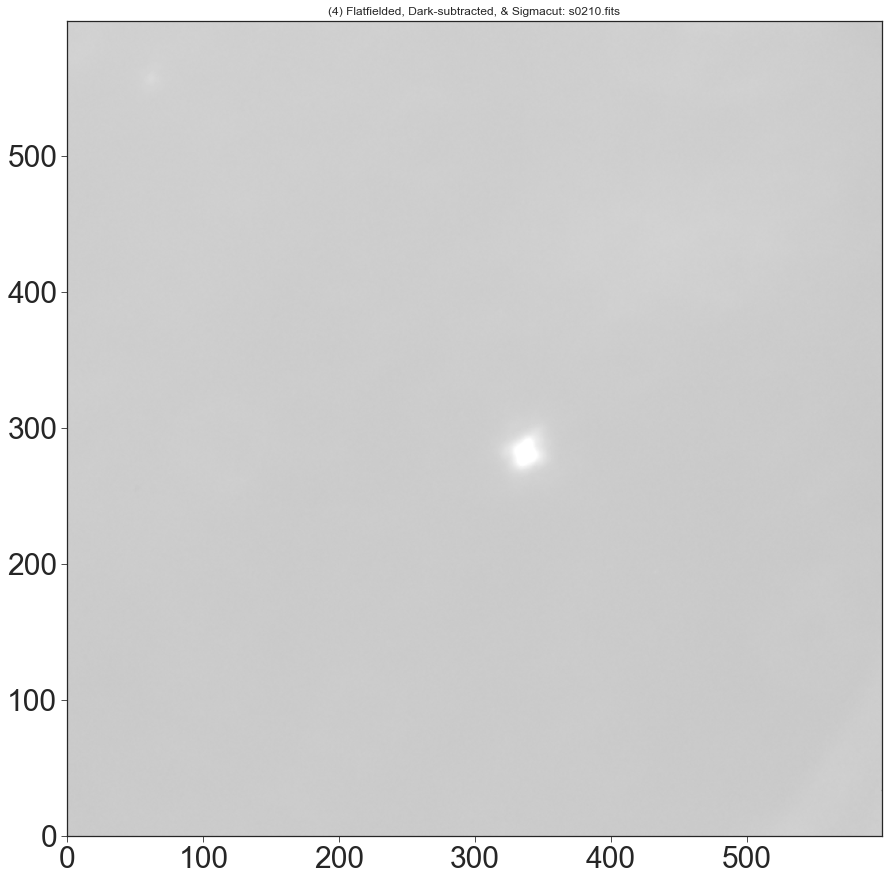

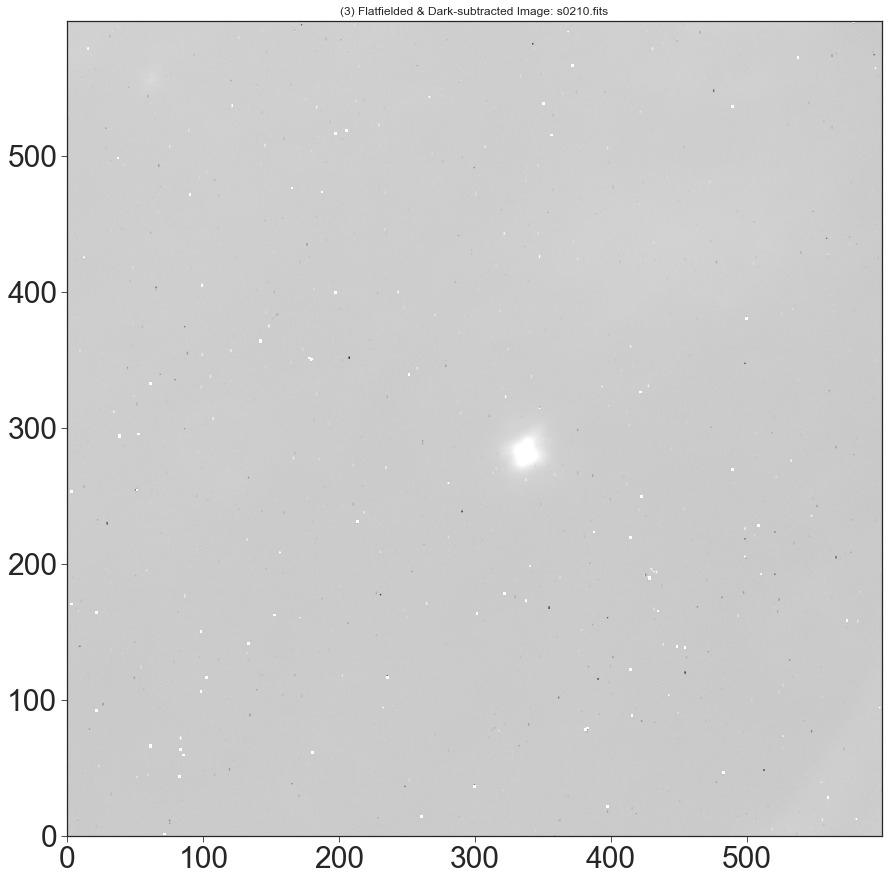

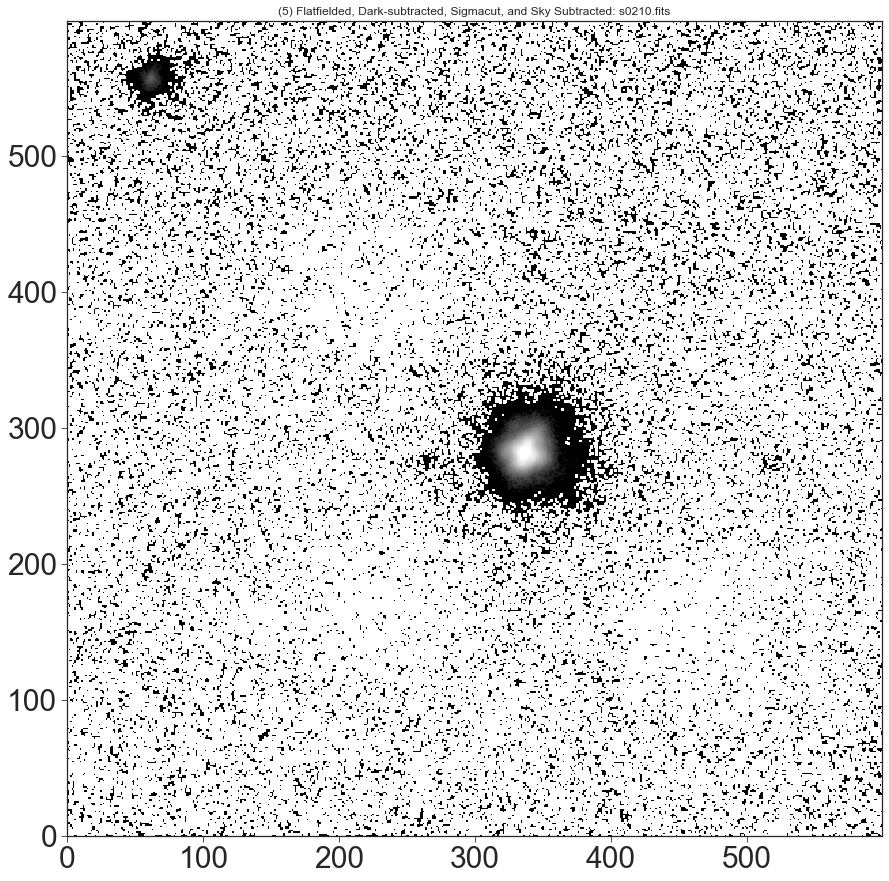

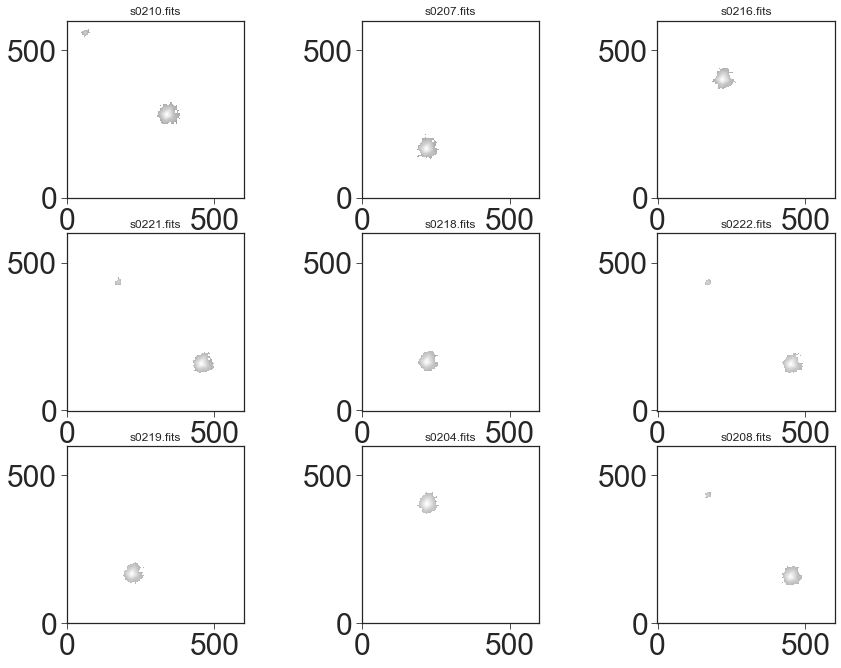

In [12]:
# so if we compare the initial raw science frame (1), to a dark-corrected (2), a flatfield & dark-corrected frame (3), and CR-removed (4) 
# we can see the progression in lessening noise

## grayscale mapping min/max values: 


im = 0  ## the image we're looking at.

## (1) raw image
im1 = object_list[im]
data_im1 = raw_image_data[im1]

## (2) dark-corrected image
data_im1_d = darkcor_data_out[im1]

## (3) flattened and dark-corrected image
data_im1_d_f = flat_darkcor_data_out[im1]

## (4) flattened, dark-corrected, Sigma_Cut, and Sky Subtracted Image
data_im1_d_f_s = flat_darkcor_sigmacut_data[im1]

## (5) flattened, dark-corrected, Sigma_Cut, and Sky Subtracted Image
data_im1_d_f_s_s = sky_flat_darkcor_data_out[im1]

plt.figure(1)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1[450:1050,850:1450]), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(1) Raw Science Image: ' + im1)

plt.figure(2)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d[450:1050,850:1450]), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(2) Dark-subtracted Image: ' + im1)

plt.figure(3)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d_f[450:1050,850:1450]), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(3) Flatfielded & Dark-subtracted Image: ' + im1)

plt.figure(4)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d_f_s), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(4) Flatfielded, Dark-subtracted, & Sigmacut: ' + im1)

plt.figure(4)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d_f_s_s), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(5) Flatfielded, Dark-subtracted, Sigmacut, and Sky Subtracted: ' + im1)

    
#let's see if some cleanup here helps
         
#del flat_darkcor_data_out


## create an array of corrected target images
targetcube = np.stack([sky_flat_darkcor_data_out[science_frame] for science_frame in object_list],axis=0)

## show the images: 
plot_grid(targetcube,object_list)
            
            

In [13]:
################################
#       Image Shifting         #
################################

final_image = image_shift(object_list, center, sky_flat_darkcor_data_out, datadir)

/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


<Figure size 864x576 with 0 Axes>

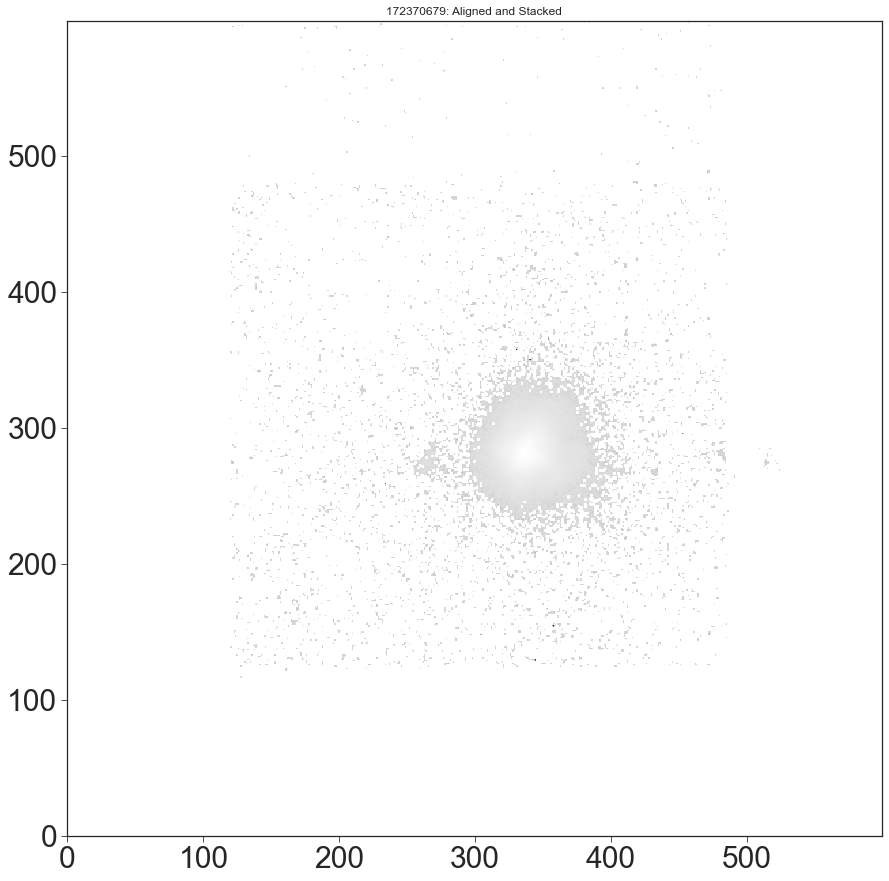

In [15]:
## show the final image array as an image: 
plt.figure(1)
plt.figure(figsize=(15,15));
plt.title(target+': Aligned and Stacked');
plt.imshow(np.log10(final_image), origin='lower', cmap='gray')
plt.savefig(outdir+target+'.png',dpi=300)

In [14]:
## Clean up and file saving

#del cr_flat_darkcor_data_out
            
print(len(object_filter_list))
#change the size of the image in the header file
header['NAXIS1'] = 600
header['NAXIS2'] = 600
header['CRPIX1'] = 300
header['CRPIX2'] = 350
            
if len(object_filter_list) > 1: 

    fits.writeto(outdir + target+'_final'+str(filter)+'.fits', final_image, header)
else:
    fits.writeto(outdir + target+'_final.fits', final_image, header)
            
            
#del raw_image_data
#del darkcor_data_out
    

1


OSError: File 'Results/172370679_final.fits' already exists.